In [2]:
# This file will be used to visualize transformer attention dumps
import pickle, pdb
import sys
sys.path.append('..')
import utils
from collections import defaultdict as ddict
import numpy as np
from helper import *

In [95]:
data = load_pickle('predictions/transformer_vis_transformer_20_05_2020_00:56:09_predictions.pkl')

In [4]:
data.keys()

dict_keys(['loss', 'metrics', 'all_preds', 'all_labels', 'all_masks', 'all_attention_weights'])

In [5]:
num_batches = len(data['all_labels'])
print (num_batches)

74


In [96]:
all_conv = []
for batch in range(num_batches):
    num_conv = data['all_preds'][batch].shape[0]
    for c in range(num_conv):
        all_conv.append({
            'preds': data['all_preds'][batch][c],
            'labels': data['all_labels'][batch][c],
            'mask': data['all_masks'][batch][c],
            'attn': data['all_attention_weights'][batch][:, c, :, :, :] 
        })
print (len(all_conv))

506


In [24]:
def get_conv_score(conv):
    '''
    Takes a conv and returns a score for it
    '''
    num_utt = int(np.sum(conv['mask']))
    preds = conv['preds'][:num_utt]
    labels = conv['labels'][:num_utt]
    from sklearn.metrics import f1_score
    macro = f1_score(preds, labels, average='macro')
    return macro

In [97]:
for c in range(len(all_conv)):
    score = get_conv_score(all_conv[c])
    all_conv[c]['score'] = score

/usr1/home/rjoshi2/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr1/home/rjoshi2/envs/myenv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [98]:
sorted_conv = sorted(all_conv, key = lambda x: x['score'], reverse = True)

In [99]:
sorted_conv[0]

{'preds': array([[1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
         1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
         0., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.,
         0., 0., 0., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
         1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
         1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 0., 1., 0., 0., 0.],
        [1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
         1., 0., 1., 0., 0., 0.]], dtype=float32),
 'labels': 

# Visualize scores

In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

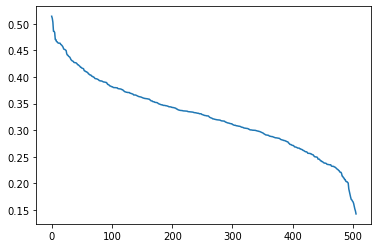

In [101]:
x = np.arange(len(sorted_conv))
y = [c['score'] for c in sorted_conv]
plt.plot(x, y)

In [102]:
# Number of conv with score > 0.45
np.sum([1 for c in sorted_conv if c['score'] > 0.45])

24

# Process data

make predictions as strategies, remove mask, make things shorter

In [45]:
temp = load_pickle('../../../data/negotiation_data/data/strategy_vector_data_w_clustered_strategies.pkl')
category2id = temp['strategies2colid']
del temp

In [46]:
#print (category2id)
id2category = {v:k for k,v in category2id.items()}
print (id2category)

{0: 'agent_id', 1: 'personal_concern', 2: 'friend', 3: 'politeness_greet', 4: 'neg_sentiment', 5: 'assertive_count', 6: 'trade_in', 7: 'number_of_diff_dic_neg', 8: 'factive_count', 9: 'third_person_plural', 10: 'liwc_informal', 11: 'third_person_singular', 12: 'liwc_certainty', 13: 'pos_sentiment', 14: 'first_person_plural_count', 15: 'propose', 16: 'number_of_diff_dic_pos', 17: 'politeness_please', 18: 'politeness_gratitude', 19: 'first_person_singular_count', 20: 'family', 21: 'hedge_count'}


In [61]:
def get_strategies_from_vec(strategies_vec):
    strats = []
    for i in range(len(strategies_vec)):
        idxes = np.where(strategies_vec[i])[0]
        strats.append([id2category[s] for s in idxes if s != 0])
    return strats

In [115]:
final_conv = []
for c in range(len(sorted_conv)):
    num_utt = int(np.sum(sorted_conv[c]['mask']))
    preds = sorted_conv[c]['preds'][:num_utt]
    labels = sorted_conv[c]['labels'][:num_utt]
    pred_strat = get_strategies_from_vec(preds)
    true_strat = get_strategies_from_vec(labels)
    attn = sorted_conv[c]['attn'][:, :, :num_utt, :num_utt]
    final_conv.append({
        'preds': pred_strat,
        'labels': true_strat,
        'attn': attn,
        'score': sorted_conv[c]['score']
    })

# Visualize Attention Maps of the 6 decoders 2 heads each

In [116]:
final_conv[0]

{'preds': [['personal_concern',
   'friend',
   'politeness_greet',
   'number_of_diff_dic_neg',
   'liwc_informal',
   'third_person_singular',
   'liwc_certainty',
   'pos_sentiment',
   'number_of_diff_dic_pos',
   'politeness_gratitude',
   'family'],
  ['assertive_count',
   'factive_count',
   'third_person_singular',
   'pos_sentiment',
   'propose',
   'politeness_please',
   'first_person_singular_count',
   'hedge_count'],
  ['personal_concern',
   'friend',
   'neg_sentiment',
   'assertive_count',
   'trade_in',
   'number_of_diff_dic_neg',
   'factive_count',
   'liwc_informal',
   'third_person_singular',
   'liwc_certainty',
   'pos_sentiment',
   'first_person_plural_count',
   'propose',
   'number_of_diff_dic_pos',
   'first_person_singular_count',
   'family',
   'hedge_count'],
  ['assertive_count',
   'factive_count',
   'third_person_singular',
   'pos_sentiment',
   'propose',
   'first_person_singular_count',
   'hedge_count'],
  ['personal_concern',
   'friend'

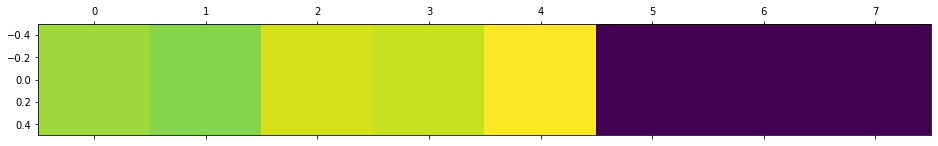

In [117]:
plt.matshow(final_conv[0]['attn'][0][0][4:5][:])

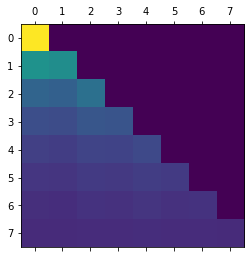

In [78]:
plt.matshow(final_conv[0]['attn'][0][0])

In [77]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [112]:
def plot_heatmap(src, trg, scores, rowwise = False):

    fig, ax = plt.subplots()
    scores2 = scores.copy()
    if rowwise:
        for i in range(len(scores2)):
            #scores2[i, :] *= (i+1)
            scores2[i, :] /= np.max(scores2[i, :])
    heatmap = ax.pcolor(scores2, cmap='viridis')

    ax.set_xticklabels(trg, minor=False, rotation='vertical')
    ax.set_yticklabels(src, minor=False)

    # put the major ticks at the middle of each cell
    # and the x-ticks on top
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(scores.shape[1]) + 0.5, minor=False)
    ax.set_yticks(np.arange(scores.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()

    plt.colorbar(heatmap)
    plt.show()

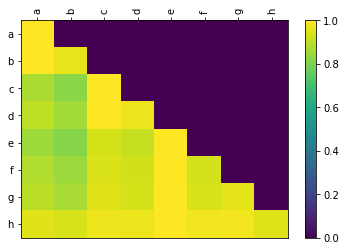

In [118]:
src = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
trg = src
scores = final_conv[0]['attn'][0][0]
plot_heatmap(src, trg, scores, rowwise=True)

## Only layer 1/2 of decoder have useful information. Layer 1 is overall and layer 2 seems too have user info.

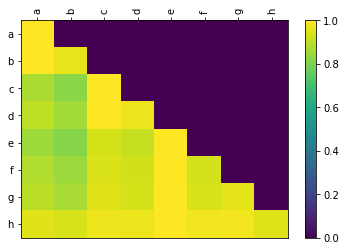

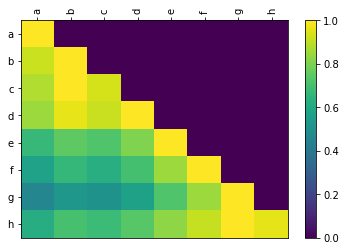

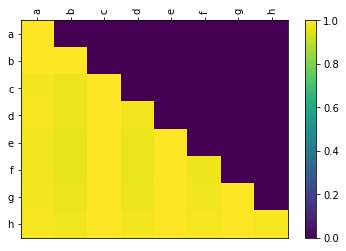

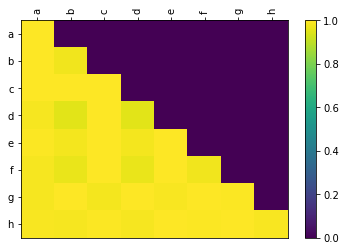

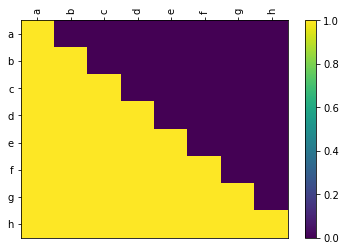

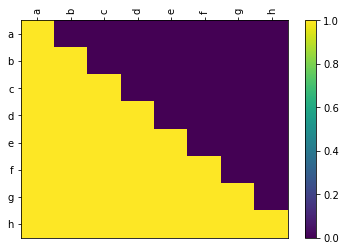

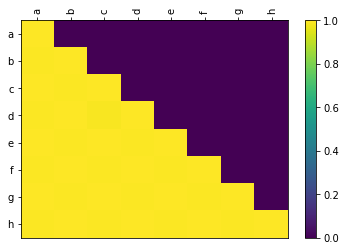

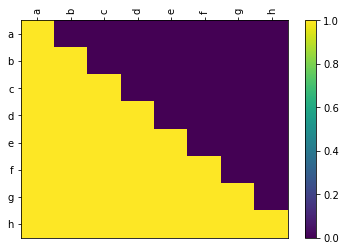

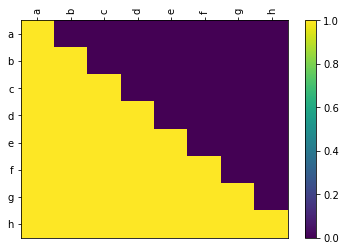

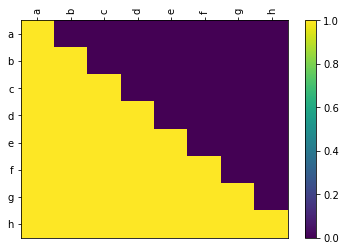

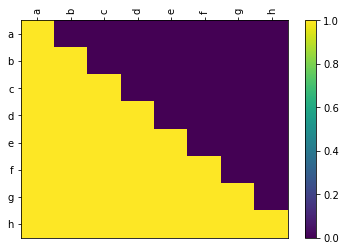

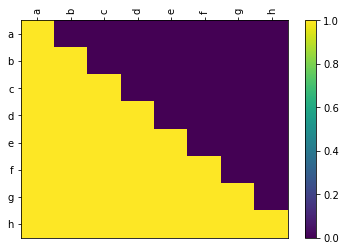

In [114]:
for layer in range(6):
    for head in range(2):
        plot_heatmap(src, trg, final_conv[0]['attn'][layer][head], True)